In [1]:
import os

data_dir = os.path.join(os.curdir, 'data')

assert os.path.exists(data_dir)

# Exercise 4

## Task 1

### a)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

help(CountVectorizer)

Help on class CountVectorizer in module sklearn.feature_extraction.text:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ---------

In [3]:
speech_path = os.path.join(data_dir, 'speech.txt')
assert os.path.exists(speech_path)

vectorizer = CountVectorizer()

with open(speech_path) as f:
    X = vectorizer.fit_transform(f).toarray()

X

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [4]:
import numpy as np

def get_most_common_ngrams(X, vectorizer):
    X_total = X.sum(axis=0)

    X_sorted_idx = np.argsort(X_total)[::-1]

    X_total_sorted = X_total[X_sorted_idx]
    vocabulary_sorted = np.array(vectorizer.get_feature_names())[X_sorted_idx]

    vocabulary_sorted = np.dstack((vocabulary_sorted, X_total_sorted))
    
    return vocabulary_sorted

# since words are actually 1-grams...
vocabulary_sorted = get_most_common_ngrams(X, vectorizer)

n_words = 10
print('Top {} words and their frequencies: '.format(n_words))
for p in vocabulary_sorted[0, :n_words]:
    print(' - {} ({} times)'.format(*p))

Top 10 words and their frequencies: 
 - the (117 times)
 - and (108 times)
 - of (93 times)
 - to (63 times)
 - we (46 times)
 - this (44 times)
 - in (43 times)
 - be (30 times)
 - for (27 times)
 - that (27 times)


Words that occur together in the same paragraph.

In [5]:
import pandas as pd

df_occurrence = pd.DataFrame(X, columns=vectorizer.get_feature_names())

df_occurrence = df_occurrence.astype(bool)

occ_corr = df_occurrence.corr(method='pearson')

occ_corr = occ_corr.unstack()

# remove the obvious values (word matching with itself)
occ_corr = occ_corr[occ_corr.index.map(lambda t: t[0] != t[1])]

occ_corr.sort_values(ascending=False).head(10)

atmosphere  deal            1.0
think       job             1.0
condense    christianity    1.0
glenn       site            1.0
seen        powerful        1.0
condense    century         1.0
await       precision       1.0
job         ought           1.0
            paid            1.0
glenn       shattered       1.0
dtype: float64

Words that occur one after another (bigram).

In [6]:
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))

with open(speech_path) as f:
    X_bigram = bigram_vectorizer.fit_transform(f).toarray()

X_bigram.shape

(59, 1749)

In [7]:
bigrams_sorted = get_most_common_ngrams(X_bigram, bigram_vectorizer)

n_bigrams = 10
print('Top {} bigrams and their frequencies: '.format(n_bigrams))
for p in bigrams_sorted[0, :n_bigrams]:
    print(' - {} ({} times)'.format(*p))

Top 10 bigrams and their frequencies: 
 - of the (20 times)
 - to be (11 times)
 - will be (11 times)
 - we have (8 times)
 - in this (8 times)
 - in the (7 times)
 - the moon (7 times)
 - it is (7 times)
 - and the (7 times)
 - that we (6 times)


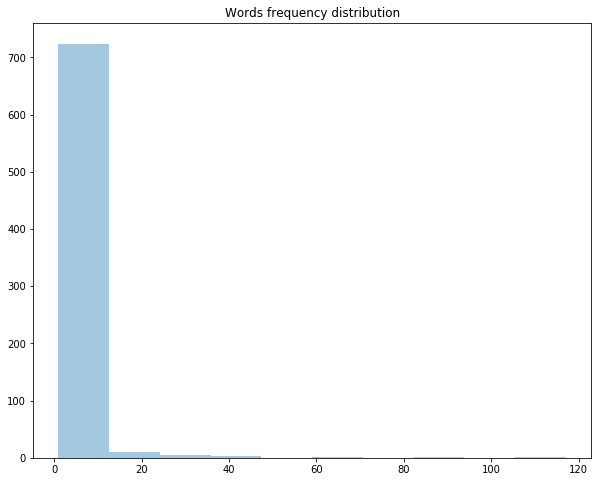

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(a=vocabulary_sorted[0,:,1][::-1], bins=10, kde=False)

plt.title('Words frequency distribution')
plt.gcf().set_size_inches((10,8))
plt.show()

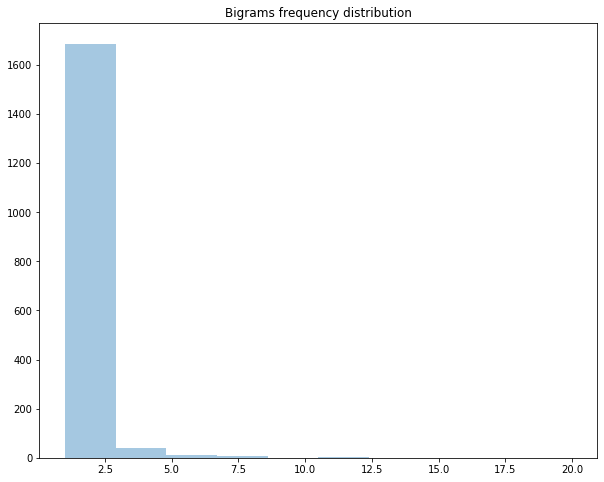

In [10]:
sns.distplot(a=bigrams_sorted[0,:,1][::-1], bins=10, kde=False)

plt.title('Bigrams frequency distribution')
plt.gcf().set_size_inches((10,8))
plt.show()

The matrices returned have several columns, and this number grows exponentially with the size of the n-grams. Besides that, most of the words are quite rare, as we can see in the histograms. Therefore, this implies in a huge dimension, which diminishes the generalization capability of machine learning models, and most of the data is not relevant because it represents rare occurrences.

### b)

In [14]:
import re

def bag_of_words(text):
    # split text into sentences by the presence of '.'
    sentences = re.split('\.[\n\s]', text)
    
    # remove '\n'
    sentences = [sentence.replace('\n', '') for sentence in sentences]
    
    # split words at non-word characters
    sentences = [re.split('\W', sentence) for sentence in sentences]
    
    # convert to lowercase
    sentences = [[word.lower() for word in sentence] for sentence in sentences]
    
    # concatenate words
    all_words = [word for sentence in sentences for word in sentence]
    all_words = set(all_words)  # drop duplicates
    try:
        all_words.remove('')  # remove empty word, if it exists
    except KeyError:
        pass
    
    # counts occurences
    word_count = [[sentence.count(word) for word in all_words] for sentence in sentences]
    
    return np.matrix(word_count), all_words

text = '''
No man can fully grasp how far and how fast we have come, but condense, if you will, the 50 thousand years of man's recorded history in a time span of but a half-century. Stated in these terms, we know very little about the first 40 years, except at the end of them advanced man had learned to use the skins of animals to cover them. Then about 10 years ago, under this standard, man emerged from his caves to construct other kinds of shelter. Only five years ago man learned to write and use a cart with wheels. Christianity began less than two years ago. The printing press came this year, and then less than two months ago, during this whole 50-year span of human history, the steam engine provided a new source of power. Newton explored the meaning of gravity. Last month electric lights and telephones and automobiles and airplanes became available. Only last week did we develop penicillin and television and nuclear power, and now if America's new spacecraft succeeds in reaching Venus, we will have literally reached the stars before midnight tonight.

This is a breathtaking pace, and such a pace cannot help but create new ills as it dispels old, new ignorance, new problems, new dangers. Surely the opening vistas of space promise high costs and hardships, as well as high reward.
'''

X, vocab = bag_of_words(text)

X

matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [15]:
X.shape

(12, 147)

In [16]:
len(vocab)

147